In [46]:
import cv2
import dlib

print(cv2.__version__)
print(dlib.__version__)

4.5.3
19.22.1


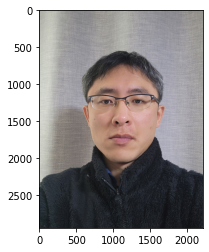

In [87]:
import matplotlib.pyplot as plt

# 얼굴 이미지 경로
my_face_image = 'front.jpg'

# 이미지 읽기와 컬러 변환
img_bgr = cv2.imread(my_face_image)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 이미지 출력
img_show = img_rgb.copy()
plt.imshow(img_show)
plt.show()

In [88]:
# 얼굴 인식
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)
print(dlib_rects)

rectangles[[(617, 1043) (1575, 2002)]]


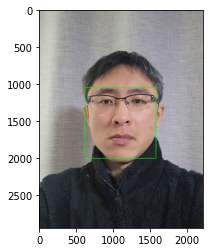

In [59]:
# 얼굴 영역 표시
for dlib_rect in dlib_rects:
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 5, lineType=cv2.LINE_AA)

plt.imshow(img_show)
plt.show()

In [60]:
# 얼굴 랜드마크 인식
model_path = 'shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


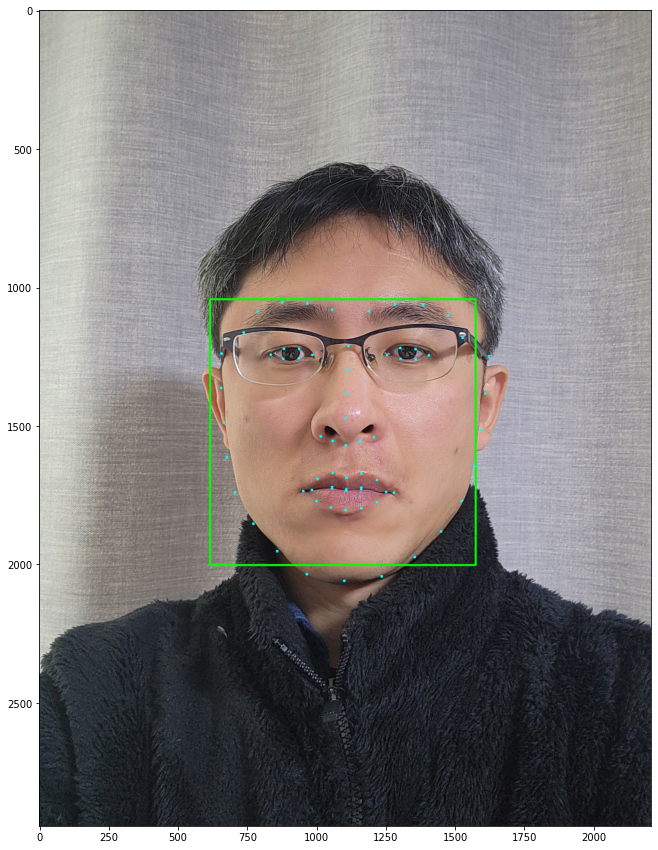

In [61]:
# 얼굴 랜드마크 표시
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 5, (0, 255, 255), -1)

plt.figure(figsize=(15,15))
plt.imshow(img_show)
plt.show()

In [62]:
# 스티커 불러오기
sticker_path = 'cat-whiskers.png'
img_sticker = cv2.imread(sticker_path, -1)
print(img_sticker.shape)
#img_sticker = cv2.resize(img_sticker, (w,h))
#print (img_sticker.shape)

(512, 512, 4)


In [68]:
# 이미지 오버레이 처리 함수 (백그라운드 이미지, 포그라운드 이미지, 위치)
def OverlayImage(bg, fg, pos):
    #print(bg.shape)
    #print(fg.shape)
    #print(pos)
    
    bg_copy = bg.copy()

    # 포그라운드 이미지의 알파채널 분리
    fg_bgra = cv2.split(fg)
    #alpha = np.round(fg_bgra[3] / 255.0)
    alpha = fg_bgra[3] / 255.0
    fg = cv2.merge([*fg_bgra][:-1])

    #  이미지가 pos의 중심에 배열되도록 함
    fg_x = int(pos[0] - fg.shape[1] / 2)
    fg_y = int(pos[1] - fg.shape[0] / 2)
    
    # ROI 설정
    roi = bg_copy[fg_y:fg_y+fg.shape[0], fg_x:fg_x+fg.shape[1]]
    for color in range(0, 3):
        roi[:,:,color] = alpha * fg[:,:,color] +  (1 - alpha) * roi[:,:,color]
    #roi = cv2.addWeighted(roi, 1, fg, 0.3, 0)
    
    bg_copy[fg_y:fg_y+fg.shape[0], fg_x:fg_x+fg.shape[1]] = roi

    plt.figure(figsize=(15,15))
    plt.imshow(bg_copy)
    plt.show()

959 960
1.59208984375 815 815
(2944, 2208, 3)
(815, 815, 4)
[1106, 1570]


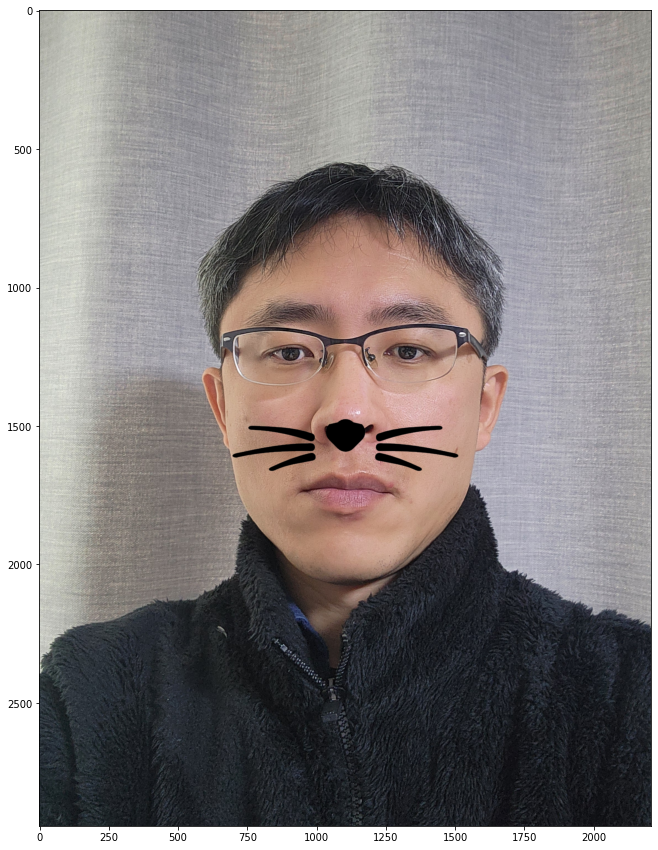

In [64]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    #print(dlib_rect.width(), dlib_rect.height())
    face_width = dlib_rect.width()
    # 코의 위치를 코 끝으로 설정
    nose_x = landmark[33][0]
    nose_y = landmark[33][1]

    # 스티커 크기 조정
    sticker_resize_rate = face_width * 0.85 / img_sticker.shape[0]
    sticker_width = int(img_sticker.shape[0] * sticker_resize_rate)
    sticker_height = int(img_sticker.shape[1] * sticker_resize_rate)
    print(sticker_resize_rate, sticker_width, sticker_height)
    resized_img_sticker = cv2.resize(img_sticker, (sticker_width, sticker_height))
    
    OverlayImage(img_rgb, resized_img_sticker, [nose_x, nose_y])   

In [69]:
# 전체 과정을 함수로 처리
def CatSticker(img_path):
    # 이미지 읽기와 컬러 변환
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 얼굴 인식
    detector_hog = dlib.get_frontal_face_detector()
    dlib_rects = detector_hog(img_rgb, 1)

    # 얼굴 랜드마크 인식
    landmark_predictor = dlib.shape_predictor(model_path)

    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        face_width = dlib_rect.width()

        # 코의 위치를 코 끝으로 설정
        nose_x = landmark[33][0]
        nose_y = landmark[33][1]

        # 스티커 읽어오기
        img_sticker = cv2.imread(sticker_path, -1)

        # 스티커 크기 조정
        sticker_resize_rate = face_width * 0.85 / img_sticker.shape[0]
        sticker_width = int(img_sticker.shape[0] * sticker_resize_rate)
        sticker_height = int(img_sticker.shape[1] * sticker_resize_rate)
        resized_img_sticker = cv2.resize(img_sticker, (sticker_width, sticker_height))
    
        # 이미지 오버레이
        OverlayImage(img_rgb, resized_img_sticker, [nose_x, nose_y])

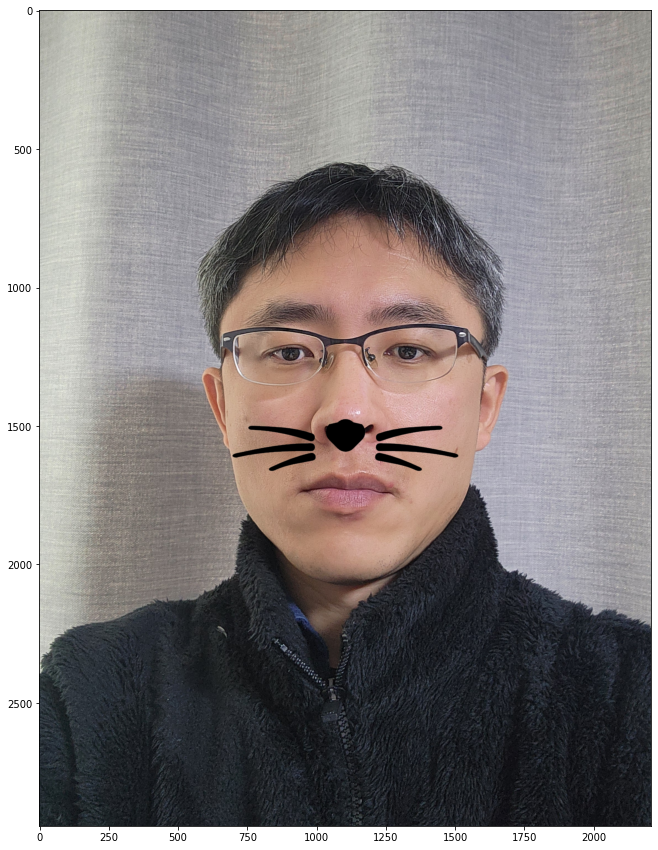

In [70]:
# 다양한 얼굴 각도 - 정면
CatSticker('front.jpg')

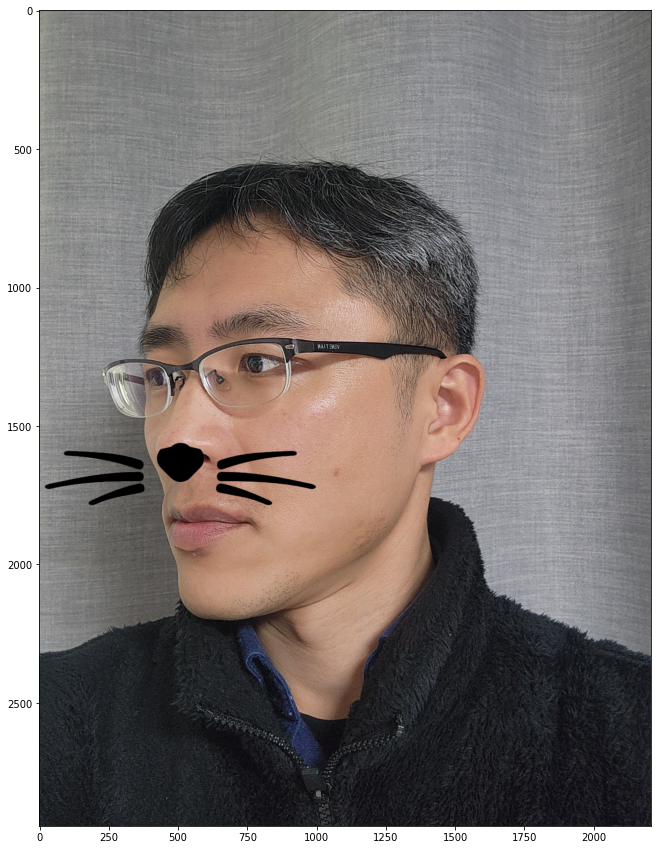

In [71]:
# 다양한 얼굴 각도 - 측면
CatSticker('left.jpg')

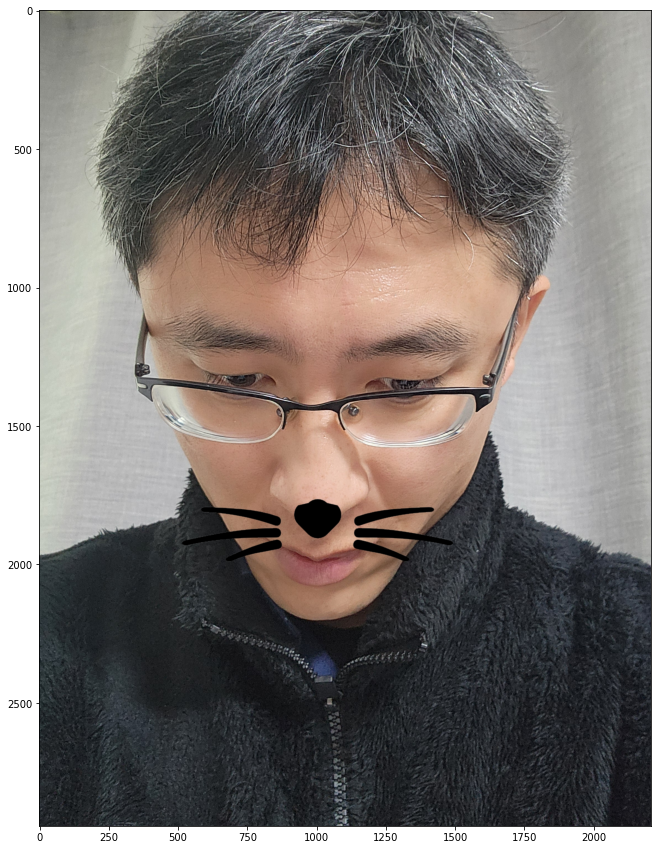

In [74]:
# 다양한 얼굴 각도 - 아래로 보기
CatSticker('down.jpg')

* 얼굴 각도에 따른 스티커 배치
- 정면 사진을 기준으로 스티커가 배치되어 얼굴 각도가 바뀌면 스티커가 어색하게 표현됨
- 얼굴을 좌우로 회전할 때 특히 문제가 두드러짐.
- 얼굴 방향에 따라 스티커 이미지를 회전시켜 오버레이 시키는 작업 필요해보임

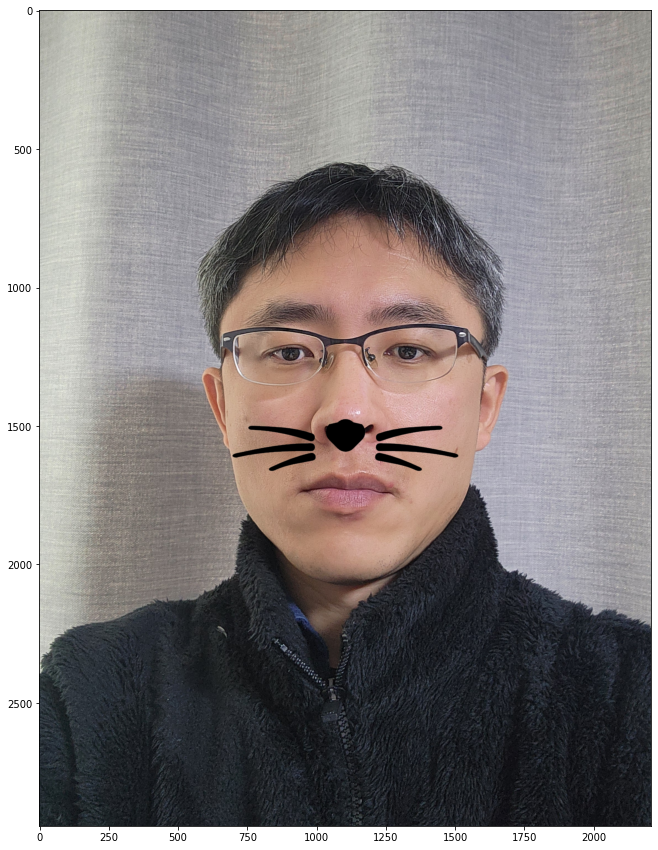

CPU times: user 7.94 s, sys: 302 ms, total: 8.24 s
Wall time: 8.16 s


In [84]:
%%time
# 실행 시간 분석
CatSticker('front.jpg')

* 실행 시간 분석
- 2208 x 2944 픽셀 기준 처리 시간이 8초 정도의 시간이 소요됨.
- 사용자의 입장에서 생각했을 때, 상당히 느린 속도.
- 실시간 처리가 가능해야 서비스로써의 이용 가치가 있다고 생각됨.
- 얼굴 영역 인식과 랜드마크 인식에 시간이 많이 소요되므로 이미지를 일정 비율로 줄여서 인식한 후에 확대하는 방식을 적용할 필요 있음

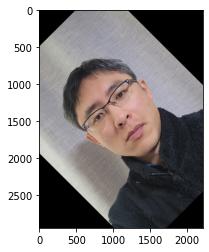

In [89]:
# 회전한 이미지 준비
# 참고: https://yunwoong.tistory.com/125

# 이미지의 크기를 잡고 이미지의 중심을 계산합니다.
(h, w) = img_rgb.shape[:2]
(cX, cY) = (w // 2, h // 2)
 
# 이미지의 중심을 중심으로 이미지를 45도 회전합니다.
M = cv2.getRotationMatrix2D((cX, cY), 45, 1.0)
rotated_img = cv2.warpAffine(img_rgb, M, (w, h))

plt.imshow(rotated_img)
plt.show()

In [90]:
# 회전된 이미지에 대해 랜드마크 인식
# 얼굴 인식
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(rotated_img, 1)

# 얼굴 랜드마크 인식
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(rotated_img, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

1.91083984375 978 978


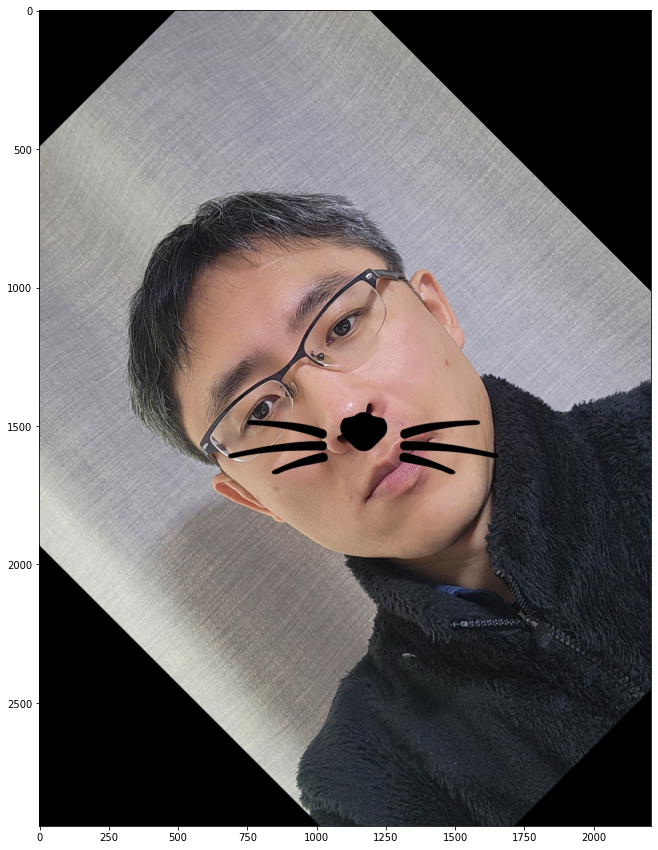

In [94]:
# 회전된 이미지에 스티커 배치
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    #print(dlib_rect.width(), dlib_rect.height())
    face_width = dlib_rect.width()
    # 코의 위치를 코 끝으로 설정
    nose_x = landmark[33][0]
    nose_y = landmark[33][1]

    # 스티커 크기 조정
    sticker_resize_rate = face_width * 0.85 / img_sticker.shape[0]
    sticker_width = int(img_sticker.shape[0] * sticker_resize_rate)
    sticker_height = int(img_sticker.shape[1] * sticker_resize_rate)
    print(sticker_resize_rate, sticker_width, sticker_height)
    resized_img_sticker = cv2.resize(img_sticker, (sticker_width, sticker_height))
    
    OverlayImage(rotated_img, resized_img_sticker, [nose_x, nose_y]) 

In [93]:
# 눈의 위치를 이용하여 얼굴의 회전 정도를 파악
# 참고: https://stackoverflow.com/questions/5015124/rotated-face-detection
# 참고: https://a292run.tistory.com/entry/Face-Alignment-for-Face-Recognition-in-Python-within-OpenCV-1

import math

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    #print(dlib_rect.width(), dlib_rect.height())
    face_width = dlib_rect.width()

    # 눈의 위치
    left_eye = landmark[36:42] # 36-41
    left_eye_max = np.max(left_eye, axis=0)
    left_eye_min = np.min(left_eye, axis=0)
    left_eye_center = (left_eye_max + left_eye_min) / 2
    #print(left_eye, left_eye_max, left_eye_min, left_eye_center)

    right_eye = landmark[42:48] # 42-47
    right_eye_max = np.max(right_eye, axis=0)
    right_eye_min = np.min(right_eye, axis=0)
    right_eye_center = (right_eye_max + right_eye_min) / 2
    #print(right_eye, right_eye_max, right_eye_min, right_eye_center)

    deg = math.atan((left_eye_center[0] - right_eye_center[0]) / (left_eye_center[1] - right_eye_center[1]))
    print("눈의 위치로 계산된 회전 각도: %.2f" % (deg * 180 / 3.141592))

눈의 위치로 계산된 회전 각도: -46.70


눈의 위치로 계산된 회전 각도: -46.70


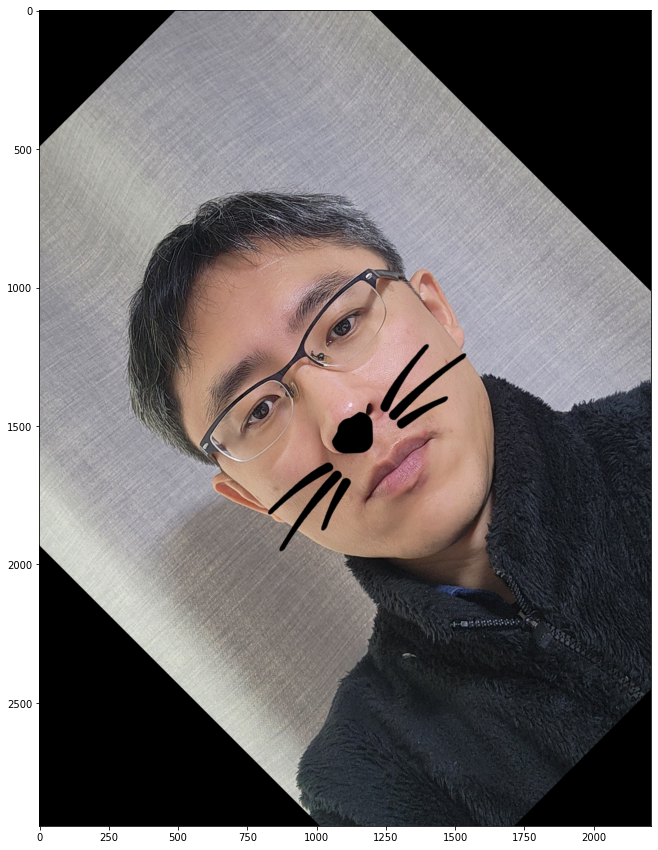

In [97]:
# 계산된 각도만큼 스티커 회전해서 이미지에 배치
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    #print(dlib_rect.width(), dlib_rect.height())
    face_width = dlib_rect.width()

    # 눈의 위치
    left_eye = landmark[36:42] # 36-41
    left_eye_max = np.max(left_eye, axis=0)
    left_eye_min = np.min(left_eye, axis=0)
    left_eye_center = (left_eye_max + left_eye_min) / 2
    #print(left_eye, left_eye_max, left_eye_min, left_eye_center)

    right_eye = landmark[42:48] # 42-47
    right_eye_max = np.max(right_eye, axis=0)
    right_eye_min = np.min(right_eye, axis=0)
    right_eye_center = (right_eye_max + right_eye_min) / 2
    #print(right_eye, right_eye_max, right_eye_min, right_eye_center)

    deg = math.atan((left_eye_center[0] - right_eye_center[0]) / (left_eye_center[1] - right_eye_center[1]))
    print("눈의 위치로 계산된 회전 각도: %.2f" % (deg * 180 / 3.141592))
    
    # 스티커 읽어오기
    img_sticker = cv2.imread(sticker_path, -1)

    # 이미지의 크기를 잡고 이미지의 중심을 계산합니다.
    (h, w) = img_sticker.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # 이미지의 중심을 중심으로 이미지를 45도 회전합니다.
    M = cv2.getRotationMatrix2D((cX, cY), -1 * (deg * 180 / 3.141592), 1.0)
    rotated_sticker = cv2.warpAffine(img_sticker, M, (w, h))

    # 코의 위치를 코 끝으로 설정
    nose_x = landmark[33][0]
    nose_y = landmark[33][1]

    # 스티커 크기 조정
    sticker_resize_rate = face_width * 0.85 / rotated_sticker.shape[0]
    sticker_width = int(rotated_sticker.shape[0] * sticker_resize_rate)
    sticker_height = int(rotated_sticker.shape[1] * sticker_resize_rate)
    #print(sticker_resize_rate, sticker_width, sticker_height)
    resized_img_sticker = cv2.resize(rotated_sticker, (sticker_width, sticker_height))
    
    OverlayImage(rotated_img, resized_img_sticker, [nose_x, nose_y])